# Example on Transfer Learning 2: Fine-tuning
In this example, we are still do image classifications on the **Dogs vs Cats** small dataset, containing 2,000 images for training, 1,000 for validation and 1,000 for testing.

To address the small dataset problem, a more refined approach would be to leverage a network pre-trained on a large dataset. Such a network would have already learned features that are useful for most computer vision problems, and leveraging such features would allow us to reach a better accuracy than any method that would only rely on the available data.

There are two ways of transfer learning in training CNNs:
1. feature extraction
2. fine-tuning

In this example, we will try the second option: **fine-tuning**.

## Setting-Up 1: Mount Google Drive to the notebook
You can easily load data from Google Drive by mounting it to the notebook with the following code.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setting-Up 2: One click to enable FREE GPU
Don't forget to enable GPU in your Colab notebook before training your model.

In Google Colab, it is very easy to do so.

From task bar, click: Runtime ⇨ Change runtime type

Choose 'GPU' in the Hardware accelerator.

## Dataset

Before you start this notebook, make sure the small dataset `dogs-vs-cats-small/`, which was generated in `dogs_vs_cats.ipynb`, is saved in your Google Drive. We will not repeat the "Downloading data ==> Creating small dataset" process in this notebook.

In [2]:
import os
gdrive_dir = '/content/drive/MyDrive/Colab Notebooks'
base_dir = gdrive_dir+'/data/dogs-vs-cats-small'#change here to the small dataset path in your drive
if not os.path.exists(base_dir):
  print(base_dir +' does not exist.')

train_dir = os.path.join(base_dir,'train')
val_dir   = os.path.join(base_dir,'val')
test_dir  = os.path.join(base_dir,'test')
if not os.path.exists(train_dir):
  print(train_dir +' does not exist.')
if not os.path.exists(val_dir):
  print(val_dir +' does not exist.')
if not os.path.exists(test_dir):
  print(test_dir +' does not exist.')

n_train_per_class = 1000
n_val_per_class = 500
n_test_per_class = 500

## STEP 1: Data preprocessing
Now we need do some pre-processing before feeding the data into the network.

Roughly, the preprocessing consists of following steps.
1. Read the image files, decode them to RGB grids of pixels
2. Rescale the pixel values (integers between 0 and 255) to the [0,1] interval, to enhance training stability of neural networks.
3. Apply data augmentation (not covered in this notebook).

In [3]:
import tensorflow as tf

# Define batch size and image size
batch_size = 32
img_size = (150, 150)

# Load the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False  # Keep order for correct label mapping
)

# Load the validation dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False  # Keep order for correct label mapping
)

# Normalize images (rescale pixel values to [0,1])
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Additional Performance Optimization (Optional)
# Benefit of using AUTOTUNE:
# 1. Loads the next batch while the current batch is being processed
# 2. Reduces data loading bottlenecks
# 3. Improves training speed
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


## STEP 2: Instantiate the VGG16 convolutional base, set the fine-tuning layers
We will fine-tune the VGG16 model pretrained on the large ImageNet dataset. Fine-tuning consists of freezing the lower layers, unfreezing a few top layers of the convolutional base, and jointly trainng both these top layers and the newly added fully connected layers.

This is called **fine-tuning** as it slightly adjusts the top layers of the convoultional base, in order to make them more relevant for the new task and new dataset.

In this example, we will fine-tune the last three convolutional layers (`block5_conv1`,`block5_conv2`, `block5_conv3`) and freeze all the earlier layers (set them to non-trainable).


In [4]:
from tensorflow.keras.applications import VGG16

# build the convolutional base of VGG16 network
VGG16_conv_base = VGG16(weights = 'imagenet', # the model if pre-trained on ImageNet
                  include_top = False, # do not include the FC layers
                  input_shape = (150,150,3))

# set the early layers (up to the 'block5_conv1')
# to non-trainable (weights will not be updated)
for layer in VGG16_conv_base.layers[:14]:
    layer.trainable = False

VGG16_conv_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

## STEP 3: Add fully-connected layers on top of the convolutional base
Build a CNN with the VGG16 convolutional base (early layers freezing, higher layers fine-tuning) and two new FC layers.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 9,177,089 (35.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

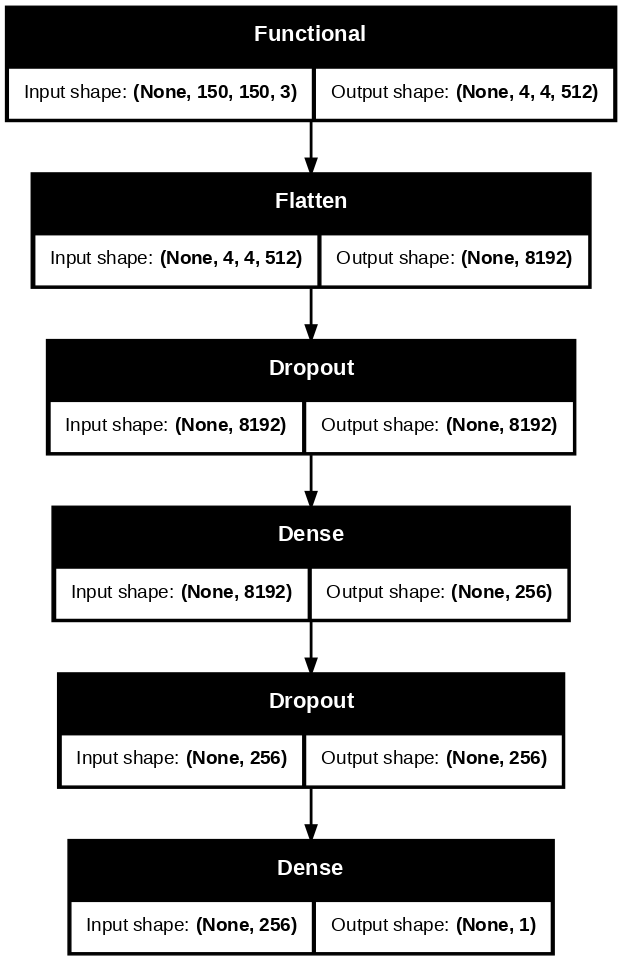

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten
# build a classifier to put on top of the convolutional model
top_model = Sequential()
top_model.add(VGG16_conv_base)
top_model.add(Flatten())
top_model.add(Dropout(0.5))#
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

top_model.summary()
from tensorflow.keras.utils import plot_model
plot_model(top_model, show_shapes=True,dpi=100) # visualize the CNN artitecture

## STEP 4: Compile the model and train it
Fine-tuning should be done with a very low learning rate, and typically with the SGD optimizer rather than an adaptative learning rate optimizer such as RMSProp.

After training, save the model and draw the learning curves.

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 523s 8s/step - accuracy: 0.7252 - loss: 0.7888 - val_accuracy: 0.5000 - val_loss: 2.3193
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.2001 - loss: 2.4420 - val_accuracy: 0.5230 - val_loss: 0.6853
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - accuracy: 0.3451 - loss: 0.7511 - val_accuracy: 0.5010 - val_loss: 0.6773
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 180ms/step - accuracy: 0.3368 - loss: 0.7599 - val_accuracy: 0.5130 - val_loss: 0.6569
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 0.3387 - loss: 0.7497 - val_accuracy: 0.5250 - val_loss: 0.6134
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.3651 - loss: 0.7641 - val_accuracy: 0.5870 - val_loss: 0.5779
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step - accuracy: 0.4153 - loss: 0.7678 - val_accuracy: 0.6640 - val_loss: 0.5459
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.5060 - loss: 0.7338 - va

Text(0.5, 0, 'epoch')

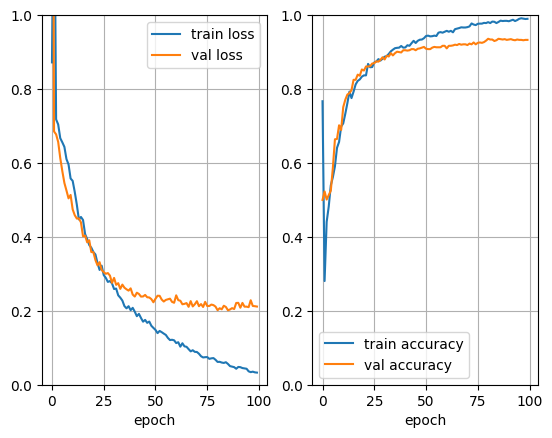

In [6]:
# compile the model with a SGD/momentum optimizer
# and a very low learning rate.
from tensorflow.keras.optimizers import SGD
top_model.compile(loss='binary_crossentropy',
              optimizer=SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])

epochs = 100
history = top_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

model_folder = '/content/drive/MyDrive/Colab Notebooks/models'
import os
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
top_model.save(model_folder+'/dogs_cats_small_VGG16_fine_tuning.keras')  # always save your model after training

# plot the learning curves
import matplotlib.pyplot as plt
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')

fig.add_subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')

**Results** The validation accuracy reaches around 93% - 3% improvement over the first transfer learning method (feature extraction without augmentation).



## STEP 5: Evaluate the model on the test set
Now, finally we evaluate this model on the test set.

In [7]:
# Load the test dataset
import tensorflow as tf
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

# Normalize images (rescale pixel values to [0,1])
normalization_layer = tf.keras.layers.Rescaling(1./255)

test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))
test_loss, test_acc = top_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Found 1000 files belonging to 2 classes.
32/32 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.9264 - loss: 0.2125
Test Accuracy: 0.9260


**Results** The test accuracy is 92.7%. In the Kaggle competition on the original dataset, this would have been on the top results. But our model is trained on a much smaller dataset, which is less than 10% training data of the original dataset.

Through this example, we can conclude that *deep CNN can be applied to even small dataset and achieve remarkable performance, thanks to the data augmentation and transfer learning*.